---
title: Training and evaluating a Word2Vec model using BlazingText in Sagemaker  
date: 2020-09-07    
comments: false  
tags: aws, sagemaker, machine learning  
keywords: python, data science, aws, sagemaker, s3, pyspark, blazingtext, word2vec, w2v, nlp

---

AWS Sagemaker has a [number of inbuilt algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html), which are not only easier to use with the Sagemaker set up but are also optimised to work with AWS architecture. At my previous job, we used [word embeddings](https://en.wikipedia.org/wiki/Word_embedding) extensively to help solve [NLP](https://en.wikipedia.org/wiki/Natural_language_processing) problems. We found that AWS's implementation of the [word2vec](https://en.wikipedia.org/wiki/Word2vec) algorithm, [BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html), is indeed much faster than training on a local machine or one of our own servers, as well as having useful inbuilt evaluation metrics that can help you work out the best model hyperparameters. I've found that models that used to take around 6 hours to train on our servers take around 30 minutes to an hour to train using BlazingText. As you'll see, the implementation on Sagemaker also makes it easier for you to compare models with different hyperparameters and keep track of the different models you've trained.

In this post and the next, I'll show you how to train and evaluate a word2vec model using BlazingText, but if you would like more detail [this video](https://www.youtube.com/watch?v=G2tX0YpNHfc) gives a very good overview of the word2vec algorithm and how it is implemented on AWS.

## Getting a dataset

For this analysis, I used the well known [Blog Authorship Corpus](http://u.cs.biu.ac.il/~koppel/BlogCorpus.htm), which consists of 681,288 posts from `blogger.com`. In order to use these data to train a word2vec model, I extracted each post, split it into its composite sentences and wrote each sentence to a new line. I then did some light normalisation, including converting the text to lowercase and removing punctuation, newline characters, and extra whitespace. If you would like some guidance on the sort of steps you can take to normalise text data, you can see [my previous blog post]({filename}2017-06-17-Text-cleaning-with-Python.md) on this topic.

Let's have a quick look at the data:

In [14]:
with open("data/training_data/cleaned_sentences.csv") as train_file:
    train = train_file.readlines()
    
for sentence in train[:5]:
    print(sentence.strip())

it saved my ass for this award at least
but my advisor was telling me about the process surrounding these awards where the teachers all cast a vote for a student each student that recieves one vote is put on the ballot for further consideration
then they check whether they meet the requirements of a b or athletics or whatever and then cull the herd accordingly
after that is what he terms the most dreaded meeting of the year where the teachers essentially have to fight for the favorites and it gets incredibly awkward
apparenty whenever it looks like one kid may get it one teacher will then being pushing for splitting the award starting another whole row of controversey


In [15]:
len(train)

7480869

You can see from the above that the data contains around 7.4 million sentences sourced from the blogs corpus. To finish, I created a new S3 bucket, uploaded these data, and I was ready to go!

## Setting up a BlazingText model

In order to be able to run our BlazingText model in Sagemaker, we need to create an [execution role](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html). This is essentially a permission that you create that allows Sagemaker to perform operations on your behalf on the AWS servers. In our case, we will need to use this role to indicate that we are giving permission for Sagemaker to run a model for us. You might need to first set up an IAM role for your Sagemaker notebook in order for this to work - I have described how to do this in a [previous blog post]({filename}2020-08-10-reading-spark-dataframe-using-sagemaker.md).

You will also need to set up a few other values. We need to specify the bucket that we wish to write our model artifacts to, and we can also create some tags that will make it a bit easier to keep track of the models we are creating. Finally, we also need to get the image of the BlazingText container that we will be using to train our model. We first need to find our current AWS region using  `boto3.Session().region_name`, and then we pass that as an argument to the `get_image_uri` method from the `sagemaker` package. We also specify when creating the container that we want to get a `blazingtext` image, and that it should be the `latest` one available.

In [1]:
import boto3
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
bucket_name = 'sagemaker-blog-corpus-nlp'
tags = [{'Key': 'user:application', 'Value': 'BlazingText'}]

region_name = boto3.Session().region_name
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")

Now that we have created these values, we can pass them to `sagemaker`'s `Estimator` [method](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html). In our estimator, we pass the container and the execution role we created earlier, telling Sagemaker that we want to train the model using our BlazingText image, and we give permission to do this using our execution role. The type of instance we're using to train is a `ml.c5.xlarge` instance: this is the "basic" machine learning instance type which is available with the [AWS Free Tier](https://aws.amazon.com/free/?all-free-tier.sort-by=item.additionalFields.SortRank&all-free-tier.sort-order=asc) account. In this estimator, we've also indicated we only want to use one instance at a time with the `train_instance_count=1` argument; however, for models that use distributed training you can increase this number for faster training. 

Just as a note about the [Sagemaker ML instance types](https://aws.amazon.com/sagemaker/pricing/instance-types/): the number in the second part of the instance name (e.g., the `c5` in `ml.c5.xlarge`) indicates the generation of that instance type, where higher numbers indicate newer generations. You should always aim to use the newest version of the instance type that is available in your region, as they will always be more efficient and therefore cheaper to use than the older generations.

We've specified also what we want the stem of our model name to be using `base_job_name`, where we want to write our model artifacts using `output_path`, what we want the maximum size of the volume where we want to store our input data using `train_volume_size` and how long we're willing to let the training job run for in seconds using `train_max_run` (I set it to 5 hours so I don't go broke!).

In [4]:
# generic Estimator class requires specifying container name
bt_model = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type='ml.c5.xlarge',
    train_volume_size=11,
    train_max_run=18000,
    base_job_name='blazingtext-blogs-sentences',
    output_path='s3://{}/models/blazingtext'.format(bucket_name),
    tags=tags
)

Finally, we need to select the hyperparameters for our word2vec model. [This link](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html) gives more information on each of these. I've chosen to use the `batch_skipgram` method in order to speed up the training process.

In [6]:
# hyperparameters can also be added through `set_hyperparameters` method
bt_model.set_hyperparameters(
    mode="batch_skipgram",
    epochs=10, 
    min_count=40,
    sampling_threshold=0.0001,
    learning_rate=0.05,
    window_size=5,
    vector_dim=100,
    negative_samples=5,
    batch_size=11,
    evaluation=True,
    subwords=False
)

## Training the model

We're finally ready to train our model! We just need to specify the path to our data in S3, and then pass this as the value of a dictionary to our estimator's `fit` method.

In [9]:
input_data = f"s3://{bucket_name}/cleaned_sentences.csv"
bt_model.fit({'train': input_data}, logs=True)

2020-06-27 16:21:33 Starting - Starting the training job...
2020-06-27 16:21:35 Starting - Launching requested ML instances......
2020-06-27 16:22:42 Starting - Preparing the instances for training...
2020-06-27 16:23:23 Downloading - Downloading input data...
2020-06-27 16:23:56 Training - Training image download completed. Training in progress..Arguments: train
[06/27/2020 16:23:56 WARNING 140271083321152] Loggers have already been setup.
[06/27/2020 16:23:56 WARNING 140271083321152] Loggers have already been setup.
[06/27/2020 16:23:56 INFO 140271083321152] nvidia-smi took: 0.0251100063324 secs to identify 0 gpus
[06/27/2020 16:23:56 INFO 140271083321152] Running single machine CPU BlazingText training using batch_skipgram mode.
[06/27/2020 16:23:56 INFO 140271083321152] Processing /opt/ml/input/data/train/cleaned_sentences.csv . File size: 676 MB
Read 10M words
Read 20M words
Read 30M words
Read 40M words
Read 50M words
Read 60M words
Read 70M words
Read 80M words
Read 90M words
Re

As you can see, the `fit` method gives us an indication of the model progress, a summary of the total billable seconds, and some evaluation metrics. We'll discuss these evaluation metrics next. You can see the model trained very quickly, taking only 12 minutes to train over 7.4 million sentences!

If we go back to our Sagemaker dashboard, we can find all of the details of our training job. Firstly, under `Training`, we click on `Training Jobs`. Then, we can go through the list of training jobs until you find our model. Clicking on the model name, we get a page with all of the relevant information for our model:

<img src="/figure/sagemaker_model_page.png" title="Model page" style="display: block; margin: auto;" />

You can see that this page includes a lot of useful information about our model, including the billable seconds and the hyperparameters we used. To get the location of the actual model artifacts in our S3 bucket, we can scroll down to the bottom of the page. You can see the path here:

<img src="/figure/blazingtext_model_path.png" title="Path to model artifacts" style="display: block; margin: auto;" />

## Evaluating the model

Sagemaker uses a gold standard set of datasets called the [WordSim353](http://alfonseca.org/eng/research/wordsim353.html) (or WS-353 for short) in order to evaluate how well our model has performed. The WS-353 datasets contain pairs of words that have been manually assessed for either their [semantic similarity or relatedness](http://www.people.vcu.edu/~btmcinnes/projects/similarity.html). For example, this is a selection of pairs from the relatedness gold standard set:

| Word 1 | Word 2 | Relatedness score |
| ------ | ------ | :---------------: |
| planet | galaxy | 8.11 |
| computer | keyboard | 7.62 |
| country | citizen | 7.31 |
| money | withdrawal | 6.88 |
| drink | mouth | 5.96 |
| space | chemistry | 4.88 |
| theater | history | 3.91 |
| media | gain | 2.88 |
| month | hotel | 1.81 |

AWS correlates the cosine similarities from our model with the manual similarities from the relatedness, similarity and the combined datasets, using a [Spearman rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient). As you can see, the `fit` method will output each of these metrics individually as part of the model training above. Sagemaker also takes the mean of these correlations as their overall objective metric, `mean_rho`. You can see this metric in the training output above, but you can also retrieve it using the following:

In [10]:
bt_model.training_job_analytics.dataframe()

,timestamp,metric_name,value
0,0.0,train:mean_rho,0.716475


If you go to the path for your model that we discussed earlier, you'll find that Sagemaker produces three files: `eval.json`, which contains all of the metrics we just discussed above, and `vectors.bin` and `vectors.txt`, which contain our model vectors. We can download these straight to our Sagemaker notebook instance using the following command.

In [ ]:
!aws s3 cp s3://sagemaker-blog-corpus-nlp/models/blazingtext/blazingtext-blogs-sentences-2020-06-27-16-21-33-136/output/model.tar.gz - | tar -xz

We can now read in our model using `gensim`.

In [3]:
!pip install gensim

from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('vectors.txt', binary=False)

Let's have a look at some words to check their neighbours:

In [6]:
word_vectors.most_similar("family")

[('grandparents', 0.8619130253791809),
 ('grandparent', 0.86134934425354),
 ('uncles', 0.8494136929512024),
 ('aunts', 0.8464415073394775),
 ('relatives', 0.8421298265457153),
 ('godparents', 0.8400623798370361),
 ('familys', 0.8268279433250427),
 ('grandmothers', 0.8248440623283386),
 ('cousins', 0.8228892683982849),
 ('nephews', 0.8178520202636719)]

In [4]:
word_vectors.most_similar("sad")

[('sadden', 0.877300500869751),
 ('happy', 0.842025876045227),
 ('dissappointed', 0.8219696283340454),
 ('dissappointing', 0.8199109435081482),
 ('dissapoint', 0.8183930516242981),
 ('pathetic', 0.8036629557609558),
 ('dissapointed', 0.8024519085884094),
 ('depressed', 0.8010575175285339),
 ('heartbroken', 0.789728045463562),
 ('saddening', 0.7896846532821655)]

We can see that both of these terms have produced good neighbours, although the neighbours for "sad" do contain a number of typos (e.g., "dissappointed"). Although typos do make poor neighbours, including them in the model (rather than correcting or removing them out during the data cleaning process) does help the coverage of the model. 

Alternatively, you can alter the training of the BlazingText model to [use subwords](https://aws.amazon.com/blogs/machine-learning/enhanced-text-classification-and-word-vectors-using-amazon-sagemaker-blazingtext/), which allows the model to find neighbours for out-of-vocabulary (OOV) words which are similar to words already in the model, such as typos or inflections. However, from what I've worked out the only way to use a model produced by BlazingText to cover OOV terms is by using a Sagemaker inference endpoint, which can be expensive.

We can also visualise how similar our most frequent terms are using [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), which is an algorithm which reduces our 100 dimension vectors to 2 dimensions. This will give us an idea of whether the model is generally doing a good job of positioning similar terms close to each other in the vector space. I copied this code directly from the AWS tutorial notebook `blazingtext_word2vec_text8.ipynb`, which you can find under the `Sagemaker Examples` tab at the top of your Jupyter notebook homepage. 

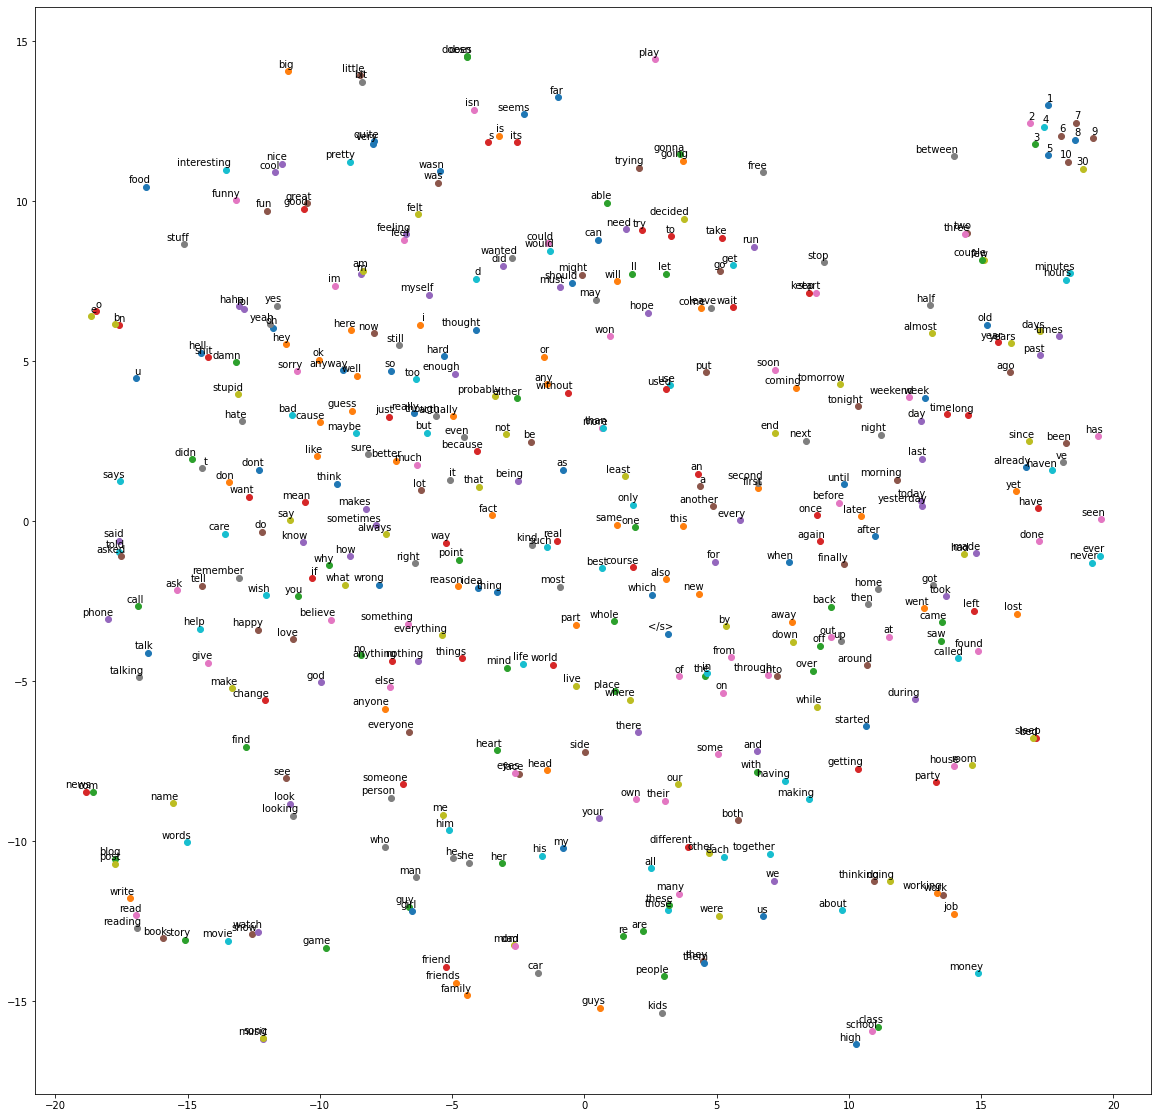

In [10]:
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from matplotlib import pylab

num_points = 400

first_line = True
index_to_word = []
with open("data/initial_model/vectors.txt","r") as f:
    for line_num, line in enumerate(f):
        if first_line:
            dim = int(line.strip().split()[1])
            word_vecs = np.zeros((num_points, dim), dtype=float)
            first_line = False
            continue
        line = line.strip()
        word = line.split()[0]
        vec = word_vecs[line_num-1]
        for index, vec_val in enumerate(line.split()[1:]):
            vec[index] = float(vec_val)
        index_to_word.append(word)
        if line_num >= num_points:
            break
word_vecs = normalize(word_vecs, copy=False, return_norm=False)

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
two_d_embeddings = tsne.fit_transform(word_vecs[:num_points])
labels = index_to_word[:num_points]

def plot(embeddings, labels):
    pylab.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.savefig('tsne_blazing_text_initial.png', bbox_inches='tight')

plot(two_d_embeddings, labels)

<img src="/figure/tsne_blazing_text_initial.png" title="T-SNE plot" style="display: block; margin: auto;" />

You can see that the model generally makes sense as you look over the graph. There is a cluster in the top righthand corner containing numbers, while in the bottom lefthand corner we have terms such as "blog", "post", "write", "read", "book" and "story" grouped.

And that's it for this tutorial! I hope this gave you a good basis for running and evaluating your own word2vec model using BlazingText. In the next post, we'll talk about how to select hyperparameters using Sagemaker's automatic model tuning, and the strengths and limitations of this approach.